# EWX Forecasting Rules

In [126]:
%matplotlib notebook
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import json
import pprint
import os
pp = pprint.PrettyPrinter(1)


In [286]:
def sortdir(filepath, num):
    os.chdir(filepath)
    files = np.array(os.listdir())
    time = []
    for file in files:
        try:
            sys_time = round(os.path.getmtime(filepath + "\\" + file))
        except:
            sys_time = round(os.path.getmtime(filepath + "/" + file))
        
        time.append(dt.datetime.fromtimestamp(sys_time))

    time = np.array(time)
    lab = ['files']
    filedf = pd.DataFrame(files, columns = lab)

    filedf['time'] = time
    filedf = filedf.sort_values(by = 'time', axis = 0, ascending = False).reset_index(drop = True)

    print("files found in dir: ", filepath)
    print(filedf.head(num))
    return(filedf.head(num))

## Read in .json Payload

In [289]:
#NEPOOL_WMECO_54024602039_024741000 - IDR
#NEPOOL_WMECO_54311202097_965441008 - SCA
os.getcwd()
filedf = sortdir(os.getcwd(), 10)

files found in dir:  /Users/stevenhurwitt/Downloads/LA-tools/EWX_Forecast
                                           files                time
0                     EWX Forecasting Copy.ipynb 2019-06-01 10:44:14
1                             .ipynb_checkpoints 2019-05-31 18:26:00
2  engie_NEPOOL_WMECO_54311202097_965441008.json 2019-05-31 18:21:12
3    ewx_NEPOOL_WMECO_54024602039_024741000.json 2019-05-31 18:21:12
4  engie_NEPOOL_WMECO_54024602039_024741000.json 2019-05-31 18:21:12
5                                        init.py 2019-05-31 18:21:12
6    ewx_NEPOOL_WMECO_54311202097_965441008.json 2019-05-31 18:21:12


## Get IDR and Scalar Data, etc.

In [298]:
def parse_engie(payload):

    with open(payload) as raw:
        idr_engie = json.load(raw)

    trnx = idr_engie['transactioninfo']
    acct = idr_engie['account']

    print('saving data files')
    ts_sca_data = acct['timeseriesdatascalar']
    ts_idr_data = acct['timeseriesdataidr'][0]

    ch = ts_idr_data['channel']
    hb = ts_idr_data['heartbeat']
    idr_payload = pd.DataFrame.from_dict(ts_idr_data['reads'])
    idr_payload.v = [float(val) for val in idr_payload.v]
    
    idr_payload.t = pd.to_datetime(idr_payload.t)
    idr_payload = idr_payload.set_index(idr_payload.t)
    idr_payload = idr_payload.drop('t', axis = 1)
    
    
    sca_payload = pd.DataFrame.from_dict(ts_sca_data).iloc[:,1:]
    sca_payload.start = pd.to_datetime(sca_payload.start)
    sca_payload.stop = pd.to_datetime(sca_payload.stop)
    sca_payload.v = [float(val) for val in sca_payload.v]

    print('saving meterid and cap tags')
    meterid = '_'.join([acct['market'], acct['discocode'], acct['accountnumber']])
    
    caps = acct['captag'][0]

    caps_df = pd.DataFrame.from_records(caps, index = [0]).iloc[:,2:]
    caps_df.start = pd.to_datetime(caps_df.start)
    caps_df.stop = pd.to_datetime(caps_df.stop)
    caps_df.v = [float(val) for val in caps_df.v]

    return(idr_payload, sca_payload, caps_df, meterid)


def parse_ewx(file):
    
    with open(file) as raw:
        print("loading json...")
        data = json.load(raw) #raw json file
        
    acct = data['account'] #get account data
    ch3 = acct['timeseriesdataidr'] #dictionary of acct attributes
    n = len(ch3)
        
    reads = ch3[0]['reads']
    master_df = pd.DataFrame.from_dict(reads)
    master_df.t = pd.to_datetime(master_df.t)
        
    print('found ', n, 'reads, creating dataset.')
        
    for i in range(1,n):
        reads = ch3[i]['reads']
        temp = pd.DataFrame.from_dict(reads)
        temp.t = pd.to_datetime(temp.t)
        master_df = pd.concat([master_df, temp]).reset_index(drop = True)
    
    print("saving to dataframe...")
    
    master_df = master_df.set_index(master_df.t)
    master_df = master_df.drop('t', axis = 1)
    
    return(master_df)

In [299]:
idr, sca, caps, meter = parse_engie(filedf.files[4])
idr = idr.loc[pd.notnull(idr.index),:]
idr.tail()

saving data files
saving meterid and cap tags


,v
t,
2019-05-20 19:00:00,1149.660
2019-05-20 20:00:00,1135.728
2019-05-20 21:00:00,1084.212
2019-05-20 22:00:00,1116.828
2019-05-20 23:00:00,1102.248


In [303]:
caps

,start,stop,sv,v
0,2018-06-01,2019-05-31 23:59:59,H,979.593


In [297]:
ewx = parse_ewx(filedf.files[3])

loading json...
found  11 reads, creating dataset.
saving to dataframe...


In [264]:
def periodic_zero(idr):
    
    tmp = idr.copy()

    tmp['d'] = [time.dayofweek for time in tmp.index]
    tmp['h'] = [time.hour for time in tmp.index]

    zeroreadmask = tmp['v'] <= .01 #margin = .01
    
    day_hr = list(zip(tmp.index.dayofweek, tmp.index.hour))
    zero_read_group = zeroreadmask.groupby([tmp.index.dayofweek, tmp.index.hour])

    weekly_periodic_reads = pd.DataFrame(zero_read_group.sum().astype(int) / zero_read_group.count())
    
    weekly_periodic_reads.index.names = ['d', 'h']
    weekly_periodic_reads.columns = ['pz']
    
    return(pd.merge(tmp, weekly_periodic_reads, how = 'left', right_index = True, left_on = ['d', 'h']))

In [267]:
zeros = periodic_zero(idr)

0

## Graph

<IPython.core.display.Javascript object>


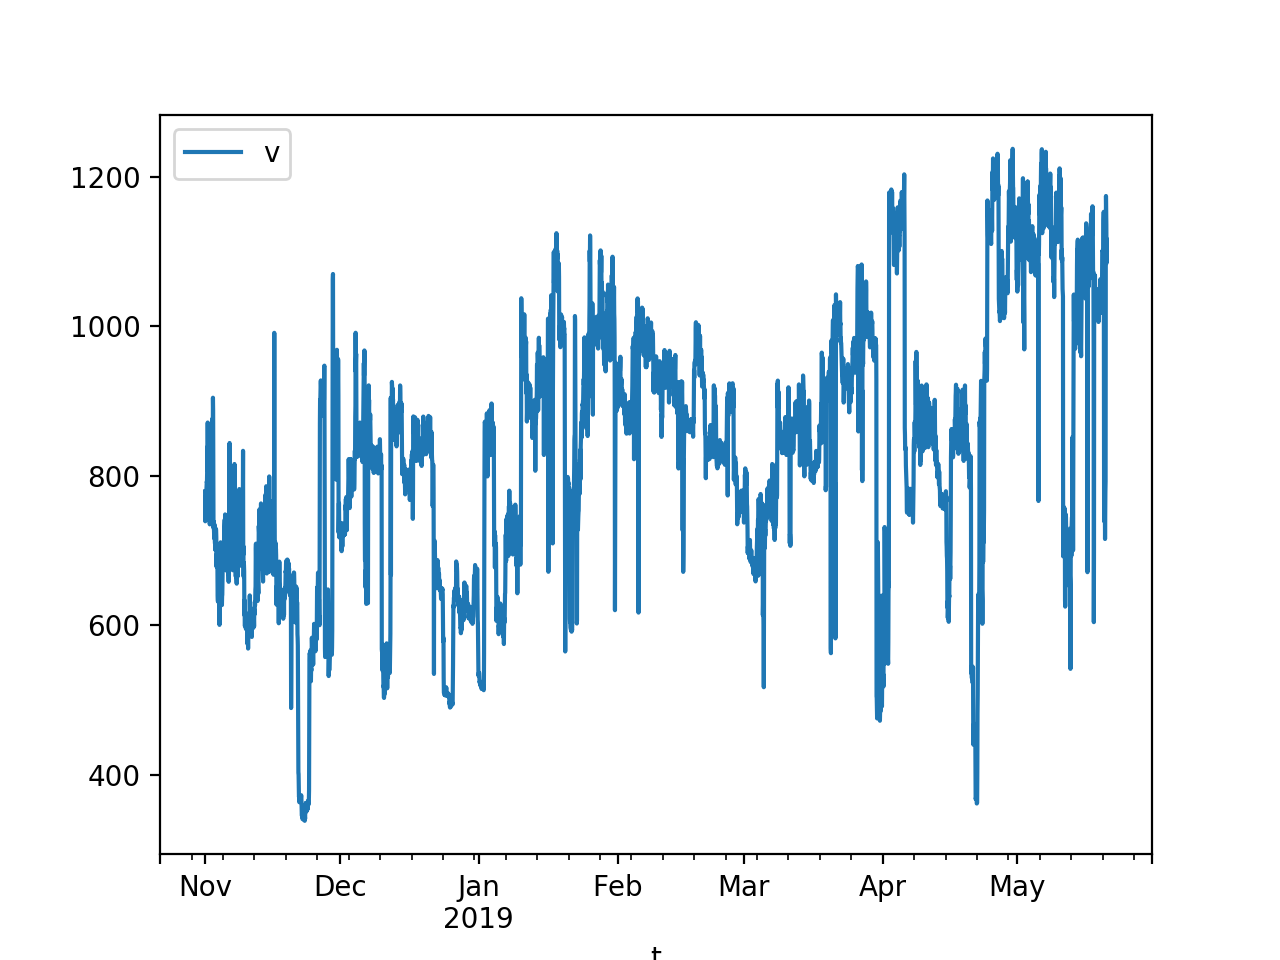

In [269]:
idr.plot(y = 'v')

<IPython.core.display.Javascript object>


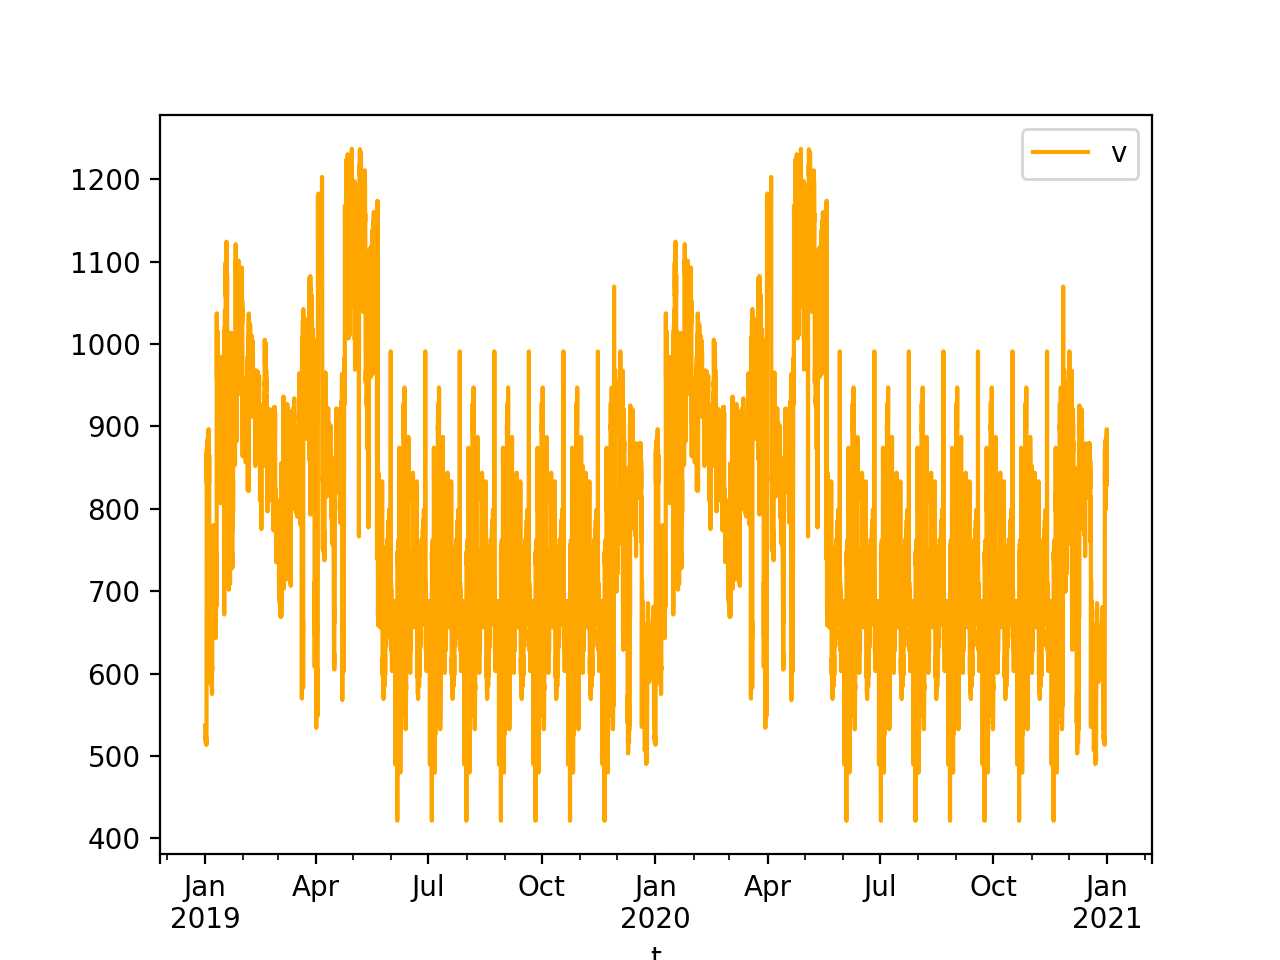

In [301]:
ewx.loc[ewx.index.year <= 2020,:].plot(y = 'v', color = 'orange')

In [257]:
with open(files[0]) as raw:
    idr_engie = json.load(raw)
        
acct = idr_engie['account']
ts_idr_data = acct['timeseriesdataidr'][0]
len(ts_idr_data['reads'])
ts_idr_data['reads'][10775]

{'t': '2015-04-10 23:00:00', 'v': '19.2'}